1 Trace(s) in Stream:
IV.P623..IVN | 2022-01-15T00:00:01.000000Z - 2022-01-15T03:37:14.000000Z | 1.0 Hz, 13034 samples


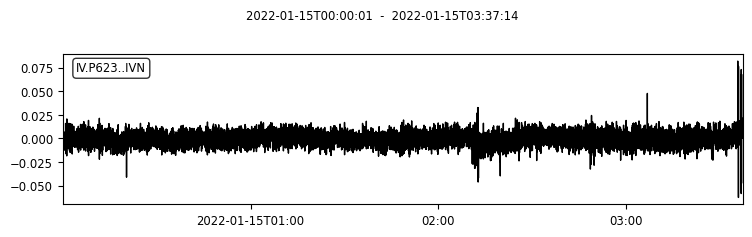

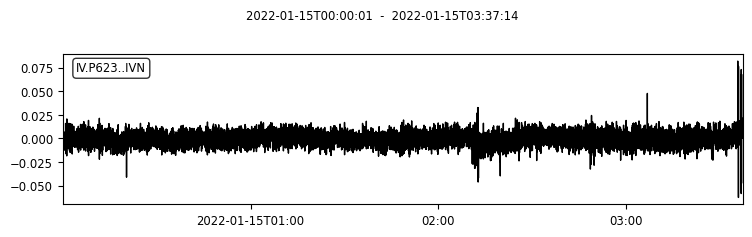

In [28]:
from obspy import UTCDateTime 
from obspy import Trace
from obspy import Stream
from obspy import read, read_inventory
from obspy.signal.cross_correlation import correlate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.cm as cmx
import datetime
import ruptures as rpt
import changefinder

st = read("/gps/highrate/MSnoise2022/2022/P623/LHN/IV.P623..LHN.2022.015.mseed", format="mseed")
print(st)
st.plot()

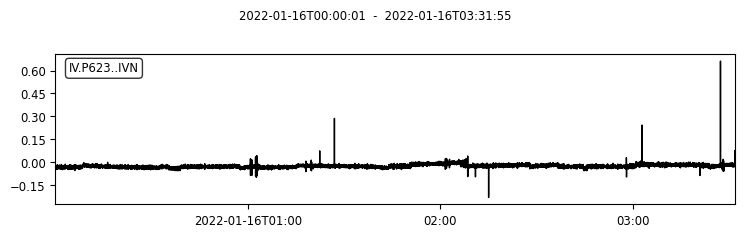

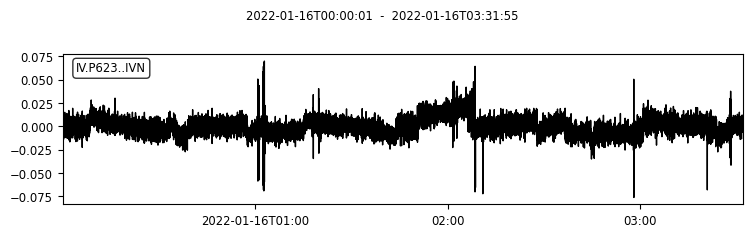

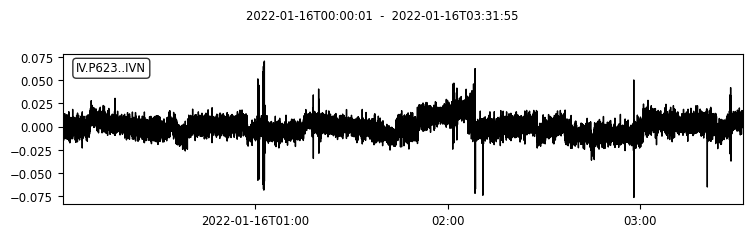

[510, 690, 1000, 1480, 1965, 2110, 2335, 3445, 3615, 3830, 4505, 4775, 5510, 5985, 6235, 6650, 7225, 7455, 7685, 8520, 8875, 8950, 9205, 9390, 9875, 9940, 10860, 12050, 12490, 12715]
[-0.00460781  0.00477495 -0.00770129 ...,  0.01161659  0.01181431
  0.00765003]


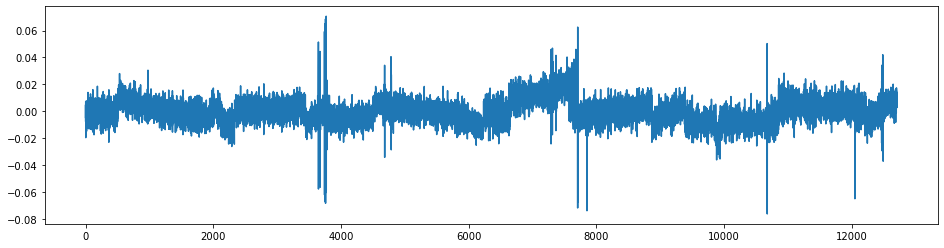

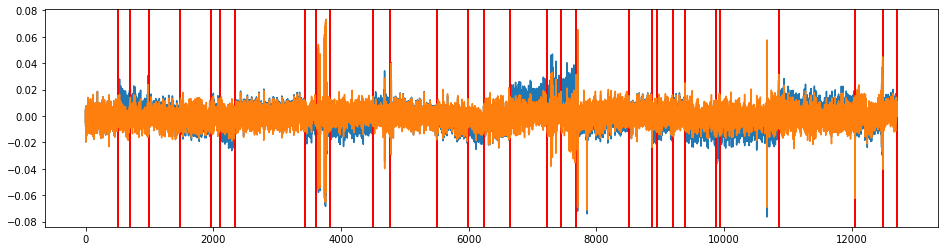

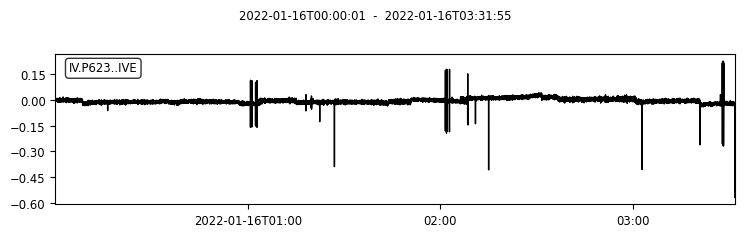

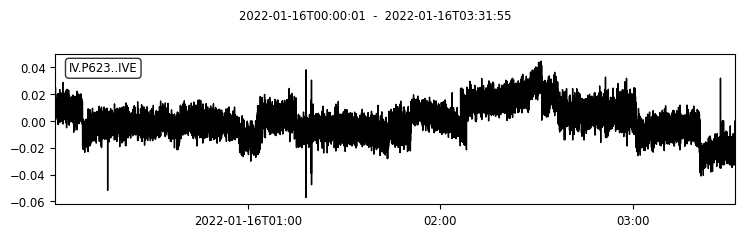

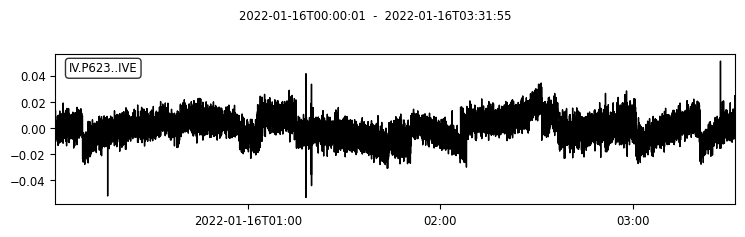

[510, 705, 1040, 1965, 2115, 2335, 3095, 3445, 3825, 4505, 5610, 5970, 6235, 6650, 7085, 7415, 7685, 8570, 8875, 9095, 9395, 10130, 10855, 11035, 11300, 11660, 12050, 12215, 12455, 12715]
[-0.00809733 -0.00130109  0.01339115 ...,  0.00186969  0.00813044
  0.0036472 ]


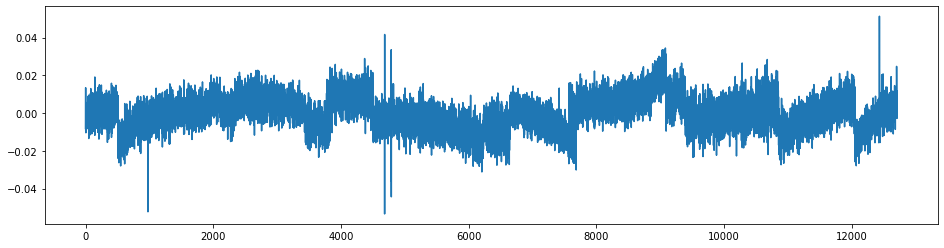

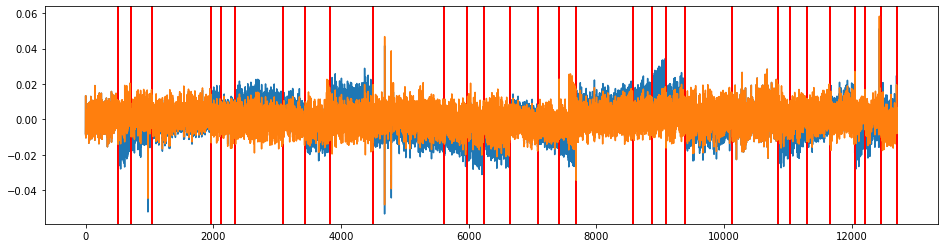

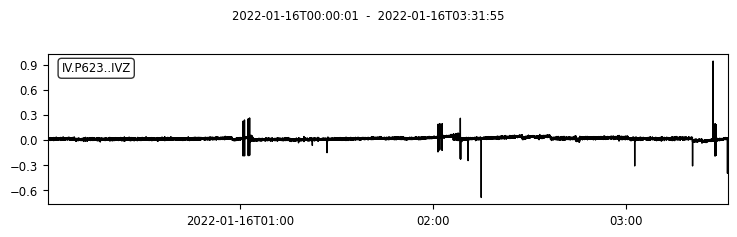

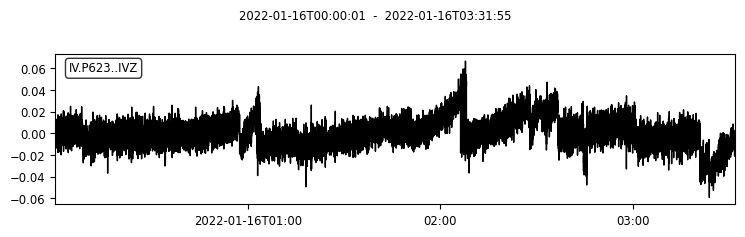

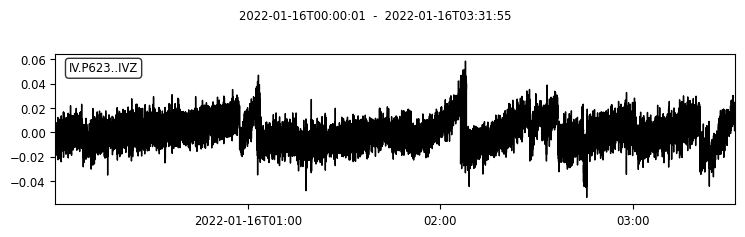

[1150, 2790, 3220, 3445, 3540, 3660, 3825, 5590, 7045, 7280, 7450, 7575, 7690, 8155, 8415, 8665, 8875, 8955, 9285, 9395, 9875, 9940, 10420, 10855, 11140, 11590, 12050, 12325, 12465, 12615, 12715]
[-0.00890046  0.00104692 -0.00633371 ...,  0.01245724  0.02230485
  0.00845146]
3 Trace(s) in Stream:
IV.P623..IVN | 2022-01-16T00:00:01.000000Z - 2022-01-16T03:31:55.000000Z | 1.0 Hz, 12715 samples
IV.P623..IVE | 2022-01-16T00:00:01.000000Z - 2022-01-16T03:31:55.000000Z | 1.0 Hz, 12715 samples
IV.P623..IVZ | 2022-01-16T00:00:01.000000Z - 2022-01-16T03:31:55.000000Z | 1.0 Hz, 12715 samples


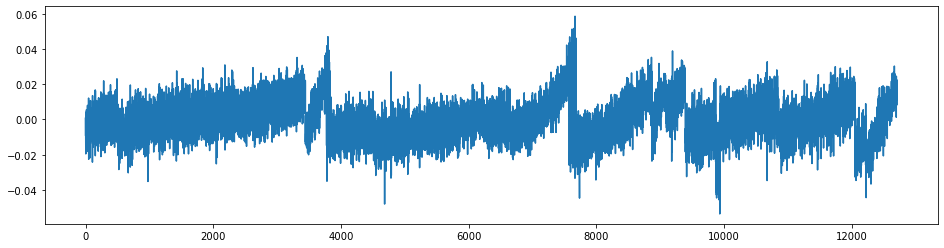

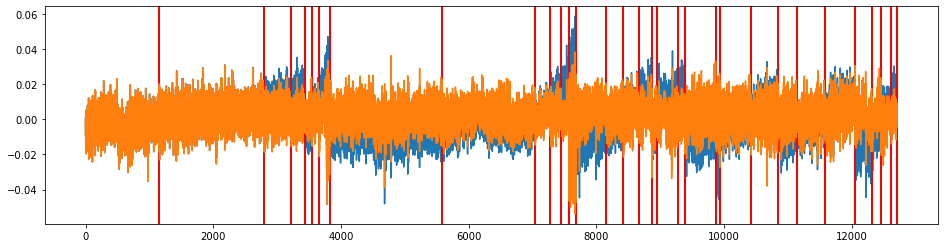

In [67]:
######## GNSS cycle correction 3 component ##################


from obspy import UTCDateTime 
from obspy import Trace
from obspy import Stream
from obspy import read, read_inventory
from obspy.signal.cross_correlation import correlate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.cm as cmx
import datetime
import ruptures as rpt
import changefinder
#import changepoint 

def plot_change_points(ts,ts_change_loc):
    plt.figure(figsize=(16,4))
    plt.plot(ts)
    for x in ts_change_loc:
        plt.axvline(x,lw=2, color='red')
        
# LOOP OVER STATIONS ANF CREAT CHANNEL STREAMS
#st = Stream(Trace())
infile = "/gps/highrate/MSnoise2022/p623/p623_1hz.L2.igr.016.phase_vels"
site = np.genfromtxt(infile, dtype=None, encoding=None, names=['date','time','dt','lat','lon','height','vx','vy','vz','sigx','sigy','sigz','vdt','vn','ve','vu','sign','sige','sigu'])

# CREATE INSTAVEL STREAMS AND REMOVE CYCLE SLIPS

#North
st_gnss_vn = Trace()
dt = UTCDateTime("2022-01-16T00:00:00.000000Z")
st_gnss_vn.stats.network = 'IV'
st_gnss_vn.stats.station = 'P623'
st_gnss_vn.stats.channel = 'IVN'       # for [I]nst[V]el [N] component]
st_gnss_vn.stats.starttime = site["date"][0] + 'T' + site["time"][0]
st_gnss_vn.stats.sampling_rate = 1
st_gnss_vn.stats.calib = 1
st_gnss_vn.data = site['vn']
st_gnss_vn.trim(dt, dt+14400)
st_gnss_vn.plot()
st_gnss_vn.detrend('linear')
st_gnss_vn.detrend('demean')
for i in range(len(st_gnss_vn.data)):
    if st_gnss_vn.data[i] > 0.08:
                st_gnss_vn.data[i] = 0
    if st_gnss_vn.data[i] < -0.08:
                st_gnss_vn.data[i] = 0
st_gnss_vn.plot()
st_gnss_vn.detrend('polynomial', order=3)
st_gnss_vn.plot()
dn = st_gnss_vn.copy()

plt.figure(figsize=(16,4))
plt.plot(dn.data)
        
# Detect the change points
algon = rpt.Pelt(model="rbf").fit(dn.data)
change_location_n = algon.predict(pen=10)
print(change_location_n)
        
# Point the change points:
plot_change_points(dn.data,change_location_n)
print(dn.data)
for i, x in enumerate(dn.data):
    if i in change_location_n:
#        dn.data[i] = 0
        dmn = dn.data[i:i+50]
        dn_mean = np.mean(dmn)
        if i < 14401:
            dn.data[i:] -= dn_mean
plt.plot(dn.data)
        
#East
st_gnss_ve = Trace()
st_gnss_ve.stats.network = 'IV'
st_gnss_ve.stats.station = 'P623'
st_gnss_ve.stats.channel = 'IVE'       # for [I]nst[V]el [E] component]
st_gnss_ve.stats.starttime = site["date"][0] + 'T' + site["time"][0]
st_gnss_ve.stats.sampling_rate = 1
st_gnss_ve.stats.calib = 1
st_gnss_ve.data = site['ve']
st_gnss_ve.trim(dt, dt+14400)
st_gnss_ve.plot()
st_gnss_ve.detrend('linear')
st_gnss_ve.detrend('demean')
for i in range(len(st_gnss_ve.data)):
    if st_gnss_ve.data[i] > 0.08:
        st_gnss_ve.data[i] = 0
    if st_gnss_ve.data[i] < -0.08:
        st_gnss_ve.data[i] = 0
st_gnss_ve.plot()
st_gnss_ve.detrend('polynomial', order=3)
st_gnss_ve.plot()
de = st_gnss_ve.copy()

plt.figure(figsize=(16,4))
plt.plot(de.data)
        
# Detect the change points
algoe = rpt.Pelt(model="rbf").fit(de.data)
change_location_e = algoe.predict(pen=10)
print(change_location_e)
        
# Point the change points:
plot_change_points(de.data,change_location_e)
print(de.data)
for i, x in enumerate(de.data):
    if i in change_location_e:
#        de.data[i] = 0
        dme = de.data[i:i+50]
        de_mean = np.mean(dme)
        if i < 14401:
            de.data[i:] -= de_mean
plt.plot(de.data)
        
#Vertical
st_gnss_vz = Trace()
st_gnss_vz.stats.network = 'IV'
st_gnss_vz.stats.station = 'P623'
st_gnss_vz.stats.channel = 'IVZ'       # for [I]nst[V]el [Z] component]
st_gnss_vz.stats.starttime = site["date"][0] + 'T' + site["time"][0]
st_gnss_vz.stats.sampling_rate = 1
st_gnss_vz.stats.calib = 1
st_gnss_vz.data = site['vz']
st_gnss_vz.trim(dt, dt+14400)
st_gnss_vz.plot()
st_gnss_vz.detrend('linear')
st_gnss_vz.detrend('demean')
for i in range(len(st_gnss_vz.data)):
    if st_gnss_vz.data[i] > 0.08:
        st_gnss_vz.data[i] = 0
    if st_gnss_vz.data[i] < -0.08:
        st_gnss_vz.data[i] = 0
st_gnss_vz.plot()
st_gnss_vz.detrend('polynomial', order=3)
st_gnss_vz.plot()
dz = st_gnss_vz.copy()

plt.figure(figsize=(16,4))
plt.plot(dz.data)
# Detect the change points

algoz = rpt.Pelt(model="rbf").fit(dz.data)
change_location_z = algoz.predict(pen=10)
print(change_location_z)
# Point the change points:
plot_change_points(dz.data,change_location_z)
print(dz.data)
for i, x in enumerate(dz.data):
    if i in change_location_z:
#        dz.data[i] = 0
        dmz = dz.data[i:i+50]
        dz_mean = np.mean(dmz)
        if i < 14401:
            dz.data[i:] -= dz_mean
plt.plot(dz.data)

#MSEED PREP

st_gnss_v = Stream(traces=[dn, de, dz])
print(st_gnss_v)
#st_gnss_v.write("/gps/highrate/MSnoise2022/2022/P623/data/IV.P623.2022.mseed", format='MSEED')
dn.write("/gps/highrate/MSnoise2022/2022/P623/LHN/IV.P623..LHN.2022.016.mseed", format='MSEED')
de.write("/gps/highrate/MSnoise2022/2022/P623/LHE/IV.P623..LHE.2022.016.mseed", format='MSEED')
dz.write("/gps/highrate/MSnoise2022/2022/P623/LHZ/IV.P623..LHZ.2022.016.mseed", format='MSEED')

P623


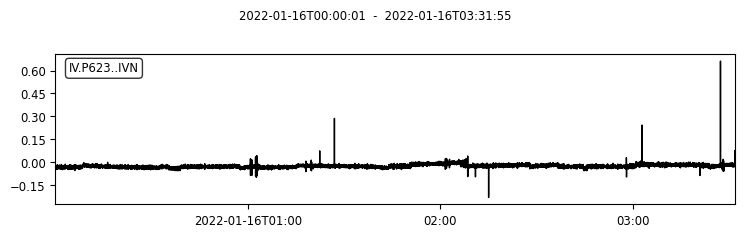

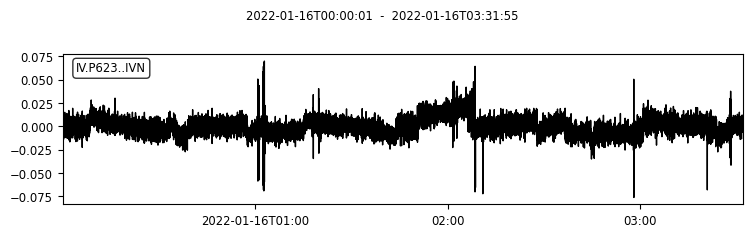

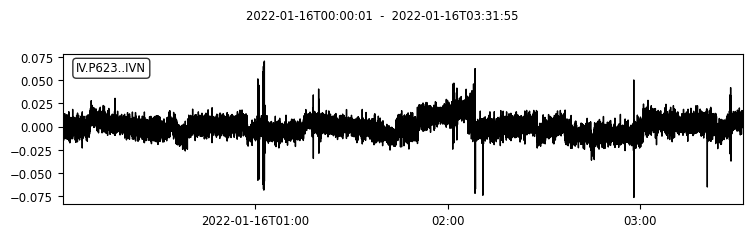

[510, 690, 1000, 1480, 1965, 2110, 2335, 3445, 3615, 3830, 4505, 4775, 5510, 5985, 6235, 6650, 7225, 7455, 7685, 8520, 8875, 8950, 9205, 9390, 9875, 9940, 10860, 12050, 12490, 12715]
[-0.00460781  0.00477495 -0.00770129 ...,  0.01161659  0.01181431
  0.00765003]


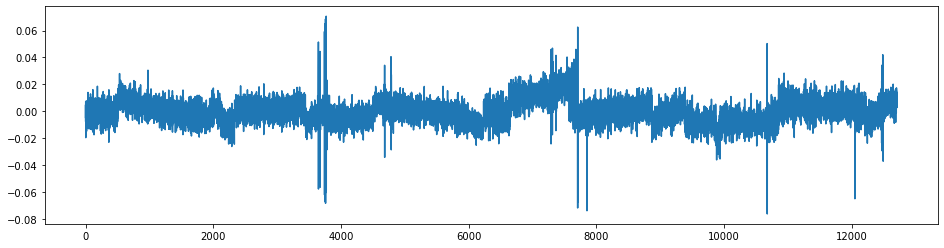

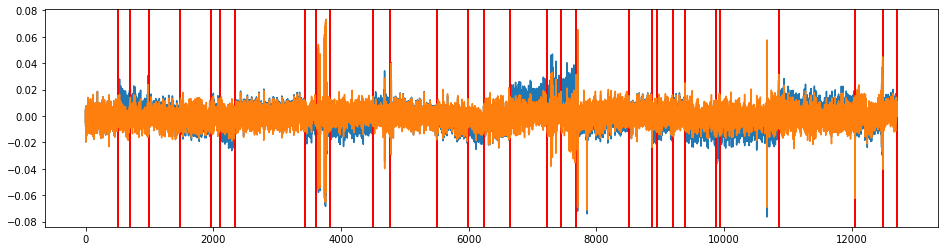

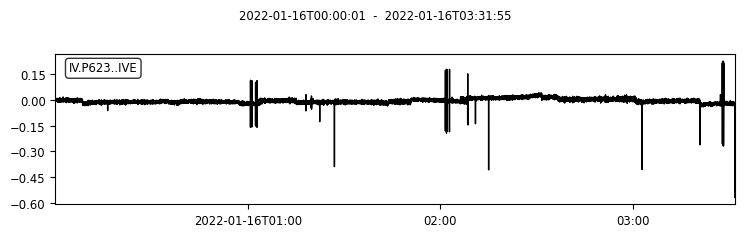

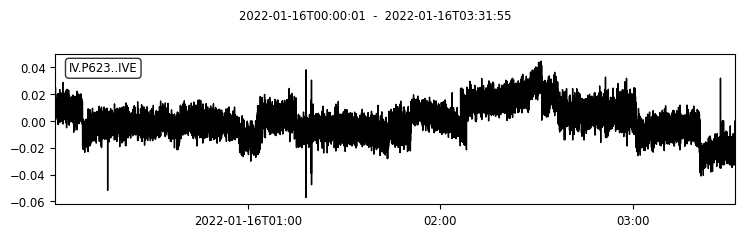

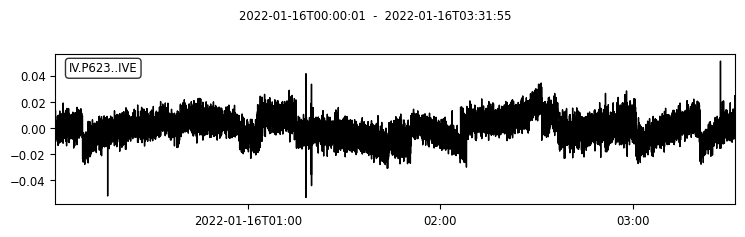

[510, 705, 1040, 1965, 2115, 2335, 3095, 3445, 3825, 4505, 5610, 5970, 6235, 6650, 7085, 7415, 7685, 8570, 8875, 9095, 9395, 10130, 10855, 11035, 11300, 11660, 12050, 12215, 12455, 12715]
[-0.00809733 -0.00130109  0.01339115 ...,  0.00186969  0.00813044
  0.0036472 ]


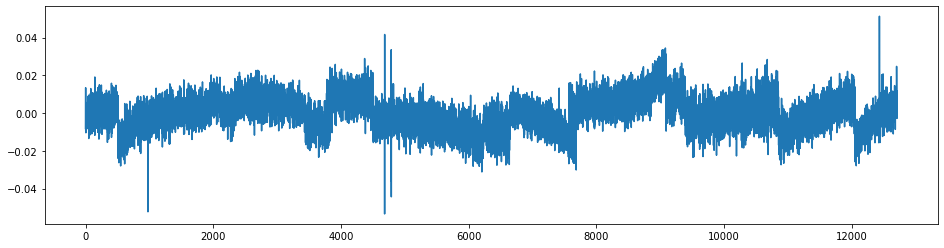

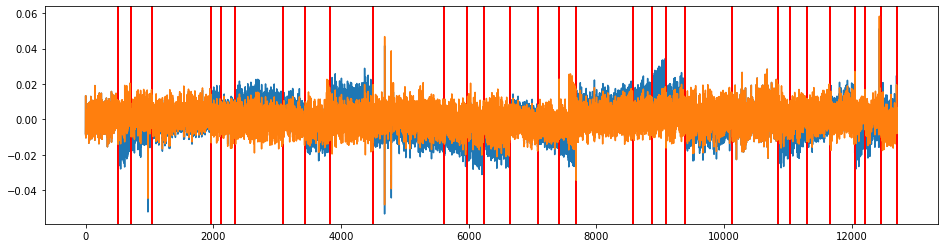

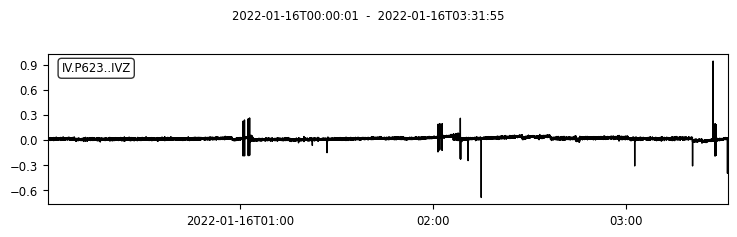

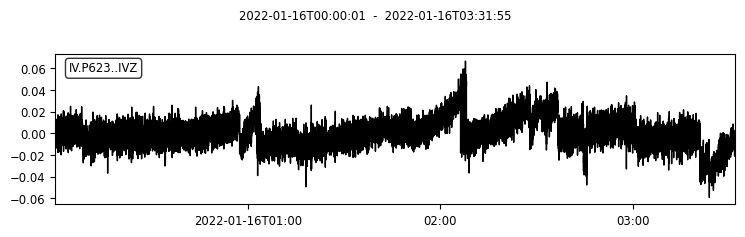

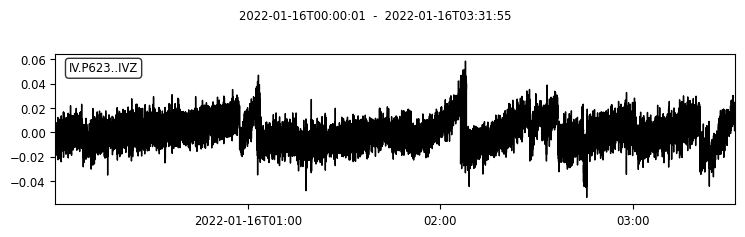

KeyboardInterrupt: 

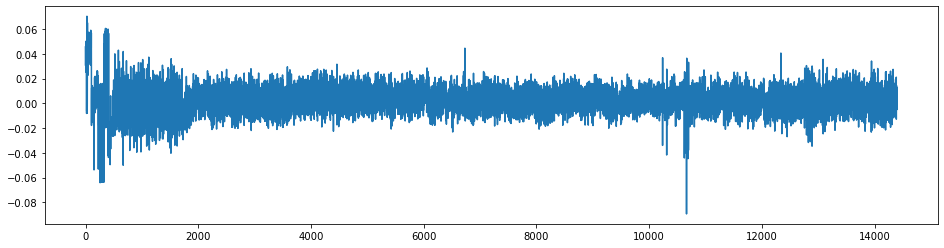

In [65]:
######## GNSS GNSS cross-correlation ##################


from obspy import UTCDateTime 
from obspy import Trace
from obspy import Stream
from obspy import read, read_inventory
from obspy.signal.cross_correlation import correlate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.cm as cmx
import datetime
import ruptures as rpt
import changefinder
#import changepoint 

def plot_change_points(ts,ts_change_loc):
    plt.figure(figsize=(16,4))
    plt.plot(ts)
    for x in ts_change_loc:
        plt.axvline(x,lw=2, color='red')
        
# LOOP OVER STATIONS ANF CREAT CHANNEL STREAMS
#st = Stream(Trace())
for sta in ["p623"]:
    for doy in ["16", "17"]:
        infile = f"/gps/highrate/MSnoise2022/{sta}/{sta}_1hz.L2.igr.0{doy}.phase_vels"
        site = np.genfromtxt(infile, dtype=None, encoding=None, names=['date','time','dt','lat','lon','height','vx','vy','vz','sigx','sigy','sigz','vdt','vn','ve','vu','sign','sige','sigu'])
        usta = sta.upper()
        print(usta)
# CREATE INSTAVEL STREAMS AND REMOVE CYCLE SLIPS

#North
        st_gnss_vn = Trace()
        dt = UTCDateTime(f"2022-01-{doy}T00:00:00.000000Z")
        st_gnss_vn.stats.network = 'IV'
        st_gnss_vn.stats.station = f'{usta}'
        st_gnss_vn.stats.channel = 'IVN'       # for [I]nst[V]el [N] component]
        st_gnss_vn.stats.starttime = site["date"][0] + 'T' + site["time"][0]
        st_gnss_vn.stats.sampling_rate = 1
        st_gnss_vn.stats.calib = 1
        st_gnss_vn.data = site['vn']
        st_gnss_vn.trim(dt, dt+14400)
        st_gnss_vn.plot()
        st_gnss_vn.detrend('linear')
        st_gnss_vn.detrend('demean')
        for i in range(len(st_gnss_vn.data)):
            if st_gnss_vn.data[i] > 0.08:
                st_gnss_vn.data[i] = 0
            if st_gnss_vn.data[i] < -0.08:
                st_gnss_vn.data[i] = 0
        st_gnss_vn.plot()
        st_gnss_vn.detrend('polynomial', order=3)
        st_gnss_vn.plot()
        dn = st_gnss_vn.copy()

        plt.figure(figsize=(16,4))
        plt.plot(dn.data)
        
        # Detect the change points
        algon = rpt.Pelt(model="rbf").fit(dn.data)
        change_location_n = algon.predict(pen=10)
        print(change_location_n)
        
        # Point the change points:
        plot_change_points(dn.data,change_location_n)
        print(dn.data)
        for i, x in enumerate(dn.data):
            if i in change_location_n:
                #dn.data[i] = 0
                dmn = dn.data[i:i+50]
                dn_mean = np.mean(dmn)
                if i < 14401:
                    dn.data[i:] -= dn_mean
        plt.plot(dn.data)
        
#East
        st_gnss_ve = Trace()
        st_gnss_ve.stats.network = 'IV'
        st_gnss_ve.stats.station = f'{usta}'
        st_gnss_ve.stats.channel = 'IVE'       # for [I]nst[V]el [E] component]
        st_gnss_ve.stats.starttime = site["date"][0] + 'T' + site["time"][0]
        st_gnss_ve.stats.sampling_rate = 1
        st_gnss_ve.stats.calib = 1
        st_gnss_ve.data = site['ve']
        st_gnss_ve.trim(dt, dt+14400)
        st_gnss_ve.plot()
        st_gnss_ve.detrend('linear')
        st_gnss_ve.detrend('demean')
        for i in range(len(st_gnss_ve.data)):
            if st_gnss_ve.data[i] > 0.08:
                st_gnss_ve.data[i] = 0
            if st_gnss_ve.data[i] < -0.08:
                st_gnss_ve.data[i] = 0
        st_gnss_ve.plot()
        st_gnss_ve.detrend('polynomial', order=3)
        st_gnss_ve.plot()
        de = st_gnss_ve.copy()

        plt.figure(figsize=(16,4))
        plt.plot(de.data)
        
        # Detect the change points
        algoe = rpt.Pelt(model="rbf").fit(de.data)
        change_location_e = algoe.predict(pen=10)
        print(change_location_e)
        
        # Point the change points:
        plot_change_points(de.data,change_location_e)
        print(de.data)
        for i, x in enumerate(de.data):
            if i in change_location_e:
                #de.data[i] = 0
                dme = de.data[i:i+50]
                de_mean = np.mean(dme)
                if i < 14401:
                    de.data[i:] -= de_mean
        plt.plot(de.data)
       
    #Vertical
        st_gnss_vz = Trace()
        st_gnss_vz.stats.network = 'IV'
        st_gnss_vz.stats.station = f'{usta}'
        st_gnss_vz.stats.channel = 'IVZ'       # for [I]nst[V]el [Z] component]
        st_gnss_vz.stats.starttime = site["date"][0] + 'T' + site["time"][0]
        st_gnss_vz.stats.sampling_rate = 1
        st_gnss_vz.stats.calib = 1
        st_gnss_vz.data = site['vz']
        st_gnss_vz.trim(dt, dt+14400)
        st_gnss_vz.plot()
        st_gnss_vz.detrend('linear')
        st_gnss_vz.detrend('demean')
        for i in range(len(st_gnss_vz.data)):
            if st_gnss_vz.data[i] > 0.08:
                st_gnss_vz.data[i] = 0
            if st_gnss_vz.data[i] < -0.08:
                st_gnss_vz.data[i] = 0
        st_gnss_vz.plot()
        st_gnss_vz.detrend('polynomial', order=3)
        st_gnss_vz.plot()
        dz = st_gnss_vz.copy()

        plt.figure(figsize=(16,4))
        plt.plot(dz.data)
        # Detect the change points

        algoz = rpt.Pelt(model="rbf").fit(dz.data)
        change_location_z = algoz.predict(pen=10)
        print(change_location_z)
        # Point the change points:
        plot_change_points(dz.data,change_location_z)
        print(dz.data)
        for i, x in enumerate(dz.data):
            if i in change_location_z:
                #dz.data[i] = 0
                dmz = dz.data[i:i+50]
                dz_mean = np.mean(dmz)
                if i < 14401:
                    dz.data[i:] -= dz_mean
        plt.plot(dz.data)

#MSEED PREP

        st_gnss_v = Stream(traces=[dn, de, dz])
        print(st_gnss_v)
        #st_gnss_v.write("/gps/highrate/MSnoise2022/2022/P623/data/IV.P623.2022.mseed", format='MSEED')
        dn.write(f"/gps/highrate/MSnoise2022/2022/{usta}/LHN/IV.{usta}..LHN.2022.0{doy}.mseed", format='MSEED')
        de.write(f"/gps/highrate/MSnoise2022/2022/{usta}/LHE/IV.{usta}..LHE.2022.0{doy}.mseed", format='MSEED')
        dz.write(f"/gps/highrate/MSnoise2022/2022/{usta}/LHZ/IV.{usta}..LHZ.2022.0{doy}.mseed", format='MSEED')
        

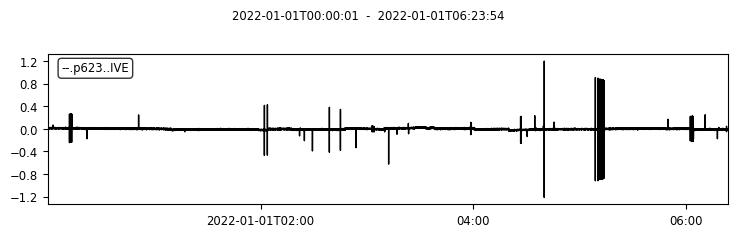

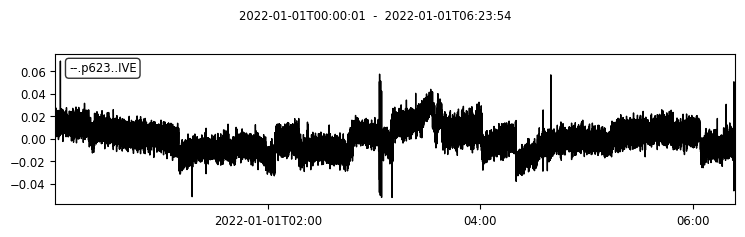

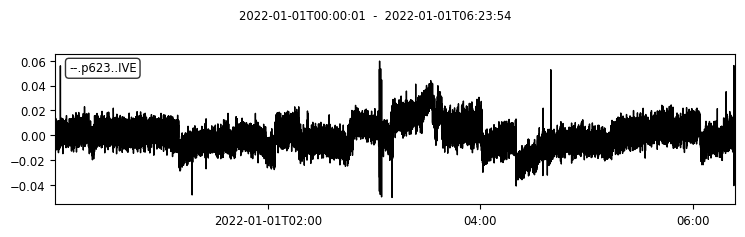

KeyboardInterrupt: 

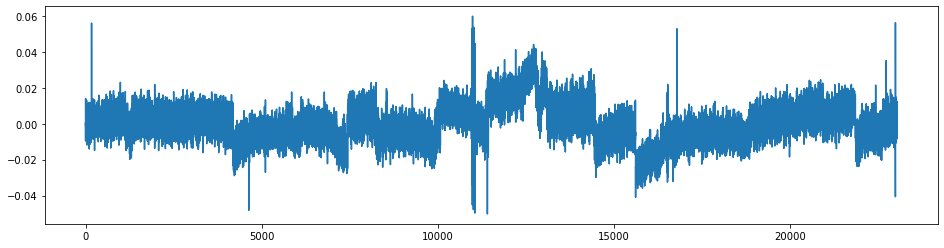

In [63]:
######## GNSS GNSS cross-correlation USING THIS!!!!!!!!!!!!!##################


from obspy import UTCDateTime 
from obspy import Trace
from obspy import Stream
from obspy import read, read_inventory
from obspy.signal.cross_correlation import correlate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.cm as cmx
import datetime
import ruptures as rpt
import changefinder
#import changepoint 

# READ INSTAVEL ASCII FILE
infile = '/home/rparameswaran/MSnoise_Backup/gnss_12hr/p623_1hz.L2.igr.phase_vels'
site = np.genfromtxt(infile, dtype=None, encoding=None, names=['date','time','dt','lat','lon','height','vx', 'vy', 'vz', 'sigx', 'sigy', 'sigz', 'vdt', 'vn', 've', 'vu', 'sign', 'sige', 'sigu'])

# CREATE AN EMPTY STREAM AND POPULATE WITH EAST INSTAVEL DATA
st_gnss_ve = Stream(Trace())
st_gnss_ve[0].stats.network = '--'
st_gnss_ve[0].stats.station = 'p623'
st_gnss_ve[0].stats.channel = 'IVE'       # for [I]nst[V]el [E] component]
st_gnss_ve[0].stats.starttime = site["date"][0] + 'T' + site["time"][0]
st_gnss_ve[0].stats.sampling_rate = 1
st_gnss_ve[0].stats.calib = 1
st_gnss_ve[0].data = site['ve']
dt = UTCDateTime("2022-01-01T00:00:00.000000Z")
st_gnss_ve[0].trim(dt, dt+43200)
st_gnss_ve[0].plot()
st_gnss_ve[0].detrend('linear')
st_gnss_ve[0].detrend('demean')
for i in range(len(st_gnss_ve[0].data)):
    if st_gnss_ve[0].data[i] > 0.08:
        st_gnss_ve[0].data[i] = 0
    if st_gnss_ve[0].data[i] < -0.08:
        st_gnss_ve[0].data[i] = 0
st_gnss_ve[0].plot()
st_gnss_ve[0].detrend('polynomial', order=3)
#st_gnss_ve[0].detrend('demean')
st_gnss_ve[0].plot()
d = st_gnss_ve[0].copy()
#ts1 = []
#ts1 = np.hstack(d.data,d.times())

plt.figure(figsize=(16,4))
plt.plot(d.data)
# Detect the change points

algo1 = rpt.Pelt(model="rbf").fit(d.data)
change_location1 = algo1.predict(pen=10)
print(change_location1)
# Point the change points:
def plot_change_points(ts,ts_change_loc):
    plt.figure(figsize=(16,4))
    plt.plot(ts)
    for x in ts_change_loc:
        plt.axvline(x,lw=2, color='red')
#
plot_change_points(d.data,change_location1)
print(d.data)
#for k in range(len(d.data)) :
#    if k+1 < 23034:
#        d.data[k+1] -= 5
print(d.data)
#print(d.data[1])
#print(d.data[4180])
#print(d.data[4181])
#print(d.data[4182])
#for i in [820, 1135, 1330, 4180, 4485, 5710, 5875, 6100, 7130, 7435, 8245, 9610, 9915, 10070, 10650, 10975, 11285, 11435, 12470, 12775, 12850, 12925, 13085, 14460, 14915, 15610, 15795, 16325, 16980, 18855, 19870, 20930, 21200, 21855, 21975, 22600]:
for i, x in enumerate(d.data):
    if i in change_location1:
#        d.data[i] = 0
#    d.data[i+1] = 0
#        print(d.data[i])
        dm = d.data[i+1:i+51]
        d_mean = np.mean(dm)
#        print(d_mean)
    
    #d.data[i:]-d_mean
        #for j in range(len(d.data)):
        if i < 23034:
            d.data[i:] -= d_mean
            
print(d.data)
print(d)
#print(d.data[1])
#print(d.data[4180])
#print(d.data[4181])
#print(d.data[4182])
plt.plot(d.data)


#def findChangePoints(ts, r, order, smooth):
#    cf = changefinder.ChangeFinder(r=r, order=order, smooth=smooth)
#    ts_score = [cf.update(p) for p in ts]
#    plt.figure(figsize=(16,4))
#    plt.plot(ts)
#    plt.figure(figsize=(16,4))
#    plt.plot(ts_score, color='red')
#    return(ts_score)

#ts_score1 = findChangePoints(d.data, r = 0.01, order = 3, smooth = 5)
#print(ts_score1(1135))
#ts_change_loc1 = pd.Series(ts_score1).nlargest(50)
#print(ts_change_loc1)
#ts_change_loc1 = ts_change_loc1.index
#ts_change_loc1


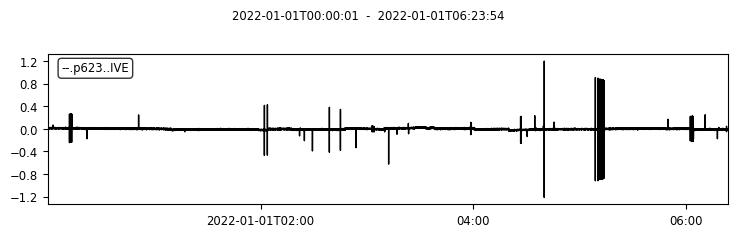

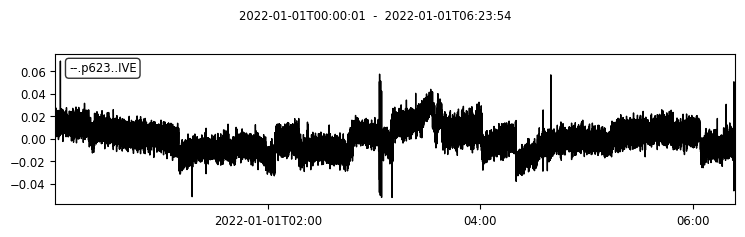

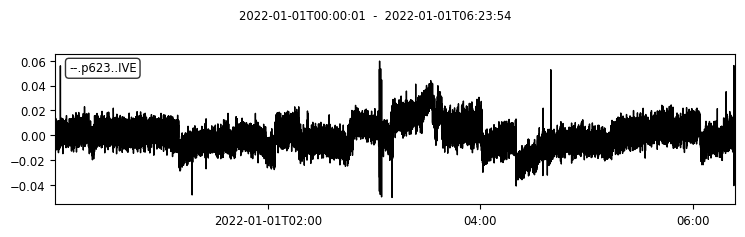

[820, 1135, 1330, 4180, 4485, 5710, 5875, 6100, 7130, 7435, 8245, 9610, 9915, 10070, 10650, 10975, 11285, 11435, 12470, 12775, 12850, 12925, 13085, 14460, 14915, 15610, 15795, 16325, 16980, 18855, 19870, 20930, 21200, 21855, 21975, 22600, 23034]
[-0.00051942  0.00049193 -0.00951573 ..., -0.00296182  0.00543749
  0.00352979]
[-0.00051942  0.00049193 -0.00951573 ..., -0.00296182  0.00543749
  0.00352979]
[-0.00051942  0.00049193 -0.00951573 ...,  0.02010219  0.02850149
  0.0265938 ]


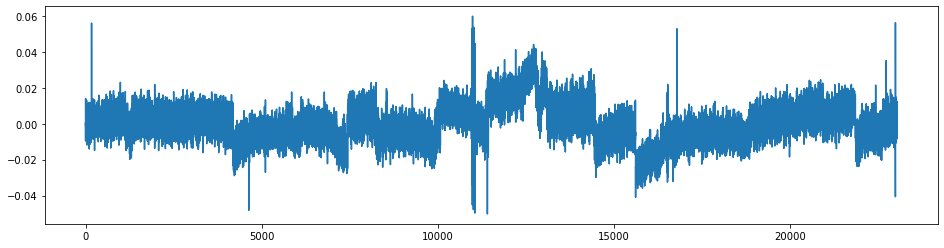

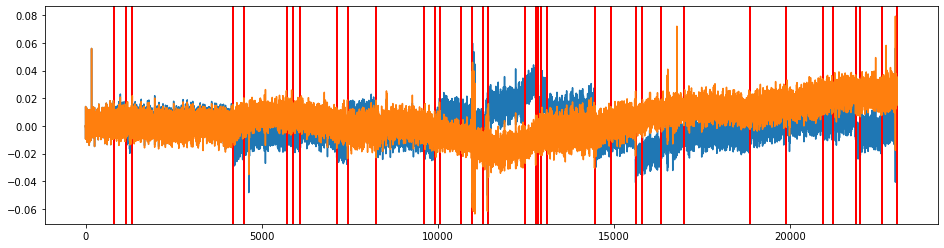

In [13]:
######## GNSS GNSS cross-correlation ##################


from obspy import UTCDateTime 
from obspy import Trace
from obspy import Stream
from obspy import read, read_inventory
from obspy.signal.cross_correlation import correlate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.cm as cmx
import datetime
import ruptures as rpt
import changefinder
#import changepoint 

# READ INSTAVEL ASCII FILE
infile = '/home/rparameswaran/MSnoise_Backup/gnss_12hr/p623_1hz.L2.igr.phase_vels'
site = np.genfromtxt(infile, dtype=None, encoding=None, names=['date','time','dt','lat','lon','height','vx', 'vy', 'vz', 'sigx', 'sigy', 'sigz', 'vdt', 'vn', 've', 'vu', 'sign', 'sige', 'sigu'])

# CREATE AN EMPTY STREAM AND POPULATE WITH EAST INSTAVEL DATA
st_gnss_ve = Stream(Trace())
st_gnss_ve[0].stats.network = '--'
st_gnss_ve[0].stats.station = 'p623'
st_gnss_ve[0].stats.channel = 'IVE'       # for [I]nst[V]el [E] component]
st_gnss_ve[0].stats.starttime = site["date"][0] + 'T' + site["time"][0]
st_gnss_ve[0].stats.sampling_rate = 1
st_gnss_ve[0].stats.calib = 1
st_gnss_ve[0].data = site['ve']
dt = UTCDateTime("2022-01-01T00:00:00.000000Z")
st_gnss_ve[0].trim(dt, dt+43200)
st_gnss_ve[0].plot()
st_gnss_ve[0].detrend('linear')
st_gnss_ve[0].detrend('demean')
for i in range(len(st_gnss_ve[0].data)):
    if st_gnss_ve[0].data[i] > 0.08:
        st_gnss_ve[0].data[i] = 0
    if st_gnss_ve[0].data[i] < -0.08:
        st_gnss_ve[0].data[i] = 0
st_gnss_ve[0].plot()
st_gnss_ve[0].detrend('polynomial', order=3)
#st_gnss_ve[0].detrend('demean')
st_gnss_ve[0].plot()
d = st_gnss_ve[0].copy()
#ts1 = []
#ts1 = np.hstack(d.data,d.times())

plt.figure(figsize=(16,4))
plt.plot(d.data)
# Detect the change points

algo1 = rpt.Pelt(model="rbf").fit(d.data)
change_location1 = algo1.predict(pen=10)
print(change_location1)
# Point the change points:
def plot_change_points(ts,ts_change_loc):
    plt.figure(figsize=(16,4))
    plt.plot(ts)
    for x in ts_change_loc:
        plt.axvline(x,lw=2, color='red')
#
plot_change_points(d.data,change_location1)
print(d.data)
#for k in range(len(d.data)) :
#    if k+1 < 23034:
#        d.data[k+1] -= 5
print(d.data)
#print(d.data[1])
#print(d.data[4180])
#print(d.data[4181])
#print(d.data[4182])
#for i in [820, 1135, 1330, 4180, 4485, 5710, 5875, 6100, 7130, 7435, 8245, 9610, 9915, 10070, 10650, 10975, 11285, 11435, 12470, 12775, 12850, 12925, 13085, 14460, 14915, 15610, 15795, 16325, 16980, 18855, 19870, 20930, 21200, 21855, 21975, 22600]:
for i, x in enumerate(d.data):
    if i in change_location1:
        dmp = np.mean(d.data[i-51:i-1])
        d.data[i] = dmp
#    d.data[i+1] = 0
#        print(d.data[i])
        dm = np.mean(d.data[i+1:i+51])
        d_diff = dmp-dm
#        print(d_mean)
    
    #d.data[i:]-d_mean
        #for j in range(len(d.data)):
        if i < 23034:
            d.data[i:] += d_diff
            
print(d.data)
#print(d.data[1])
#print(d.data[4180])
#print(d.data[4181])
#print(d.data[4182])
plt.plot(d.data)


#def findChangePoints(ts, r, order, smooth):
#    cf = changefinder.ChangeFinder(r=r, order=order, smooth=smooth)
#    ts_score = [cf.update(p) for p in ts]
#    plt.figure(figsize=(16,4))
#    plt.plot(ts)
#    plt.figure(figsize=(16,4))
#    plt.plot(ts_score, color='red')
#    return(ts_score)

#ts_score1 = findChangePoints(d.data, r = 0.01, order = 3, smooth = 5)
#print(ts_score1(1135))
#ts_change_loc1 = pd.Series(ts_score1).nlargest(50)
#print(ts_change_loc1)
#ts_change_loc1 = ts_change_loc1.index
#ts_change_loc1
